# LABORATORIUM 4 -  Linear models
## Bartosz Więcek

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [27]:
from cmdstanpy import CmdStanModel
import seaborn as sns

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [7]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Task 1. Prior predictive checks

In [8]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:compiling stan file /home/Lab_4/height_1_ppc.stan to exe file /home/Lab_4/height_1_ppc
INFO:cmdstanpy:compiled model executable: /home/Lab_4/height_1_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

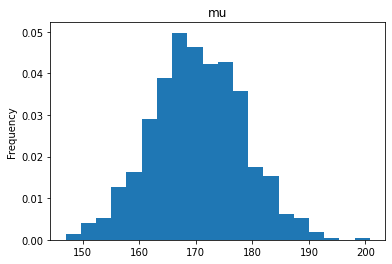

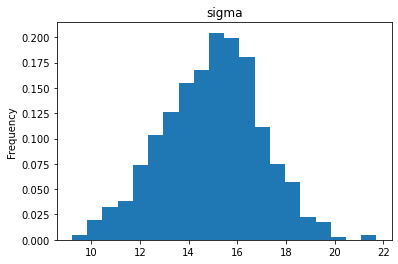

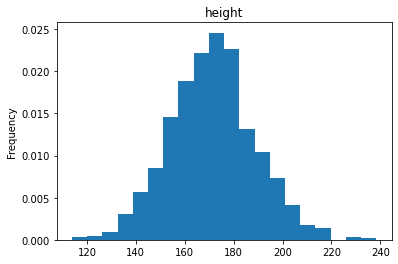

In [9]:
df_1 = sim.draws_pd()

# 1.
for signal in ['mu', 'sigma', 'height']:
    df_1[signal].plot.hist(bins=20, density=True)
    plt.title(signal)
    plt.show()

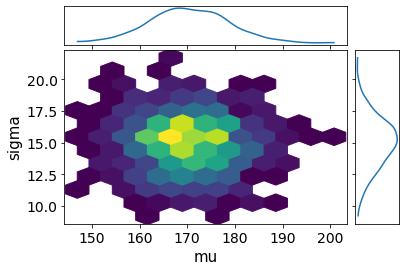

In [10]:
# 2.
az.plot_pair(sim, var_names=("mu", "sigma"), kind="hexbin", marginals=True)
plt.show()

In [15]:
# 3.
for signal in ['mu', 'sigma', 'height']:
    print(f'{signal}:  [mean={df_1[signal].mean()}  ;  std={df_1[signal].std()}]')

mu:  [mean=170.30681699999997  ;  std=8.106592452238962]
sigma:  [mean=14.963684010000001  ;  std=2.0128568333231938]
height:  [mean=171.373087  ;  std=17.429630630605754]


Samples are consistent with priors.

## Task 2. Model fit and evaluation

In [16]:
model_1_fit=CmdStanModel(stan_file='/home/Lab_4/height_1_fit.stan')

INFO:cmdstanpy:compiling stan file /home/Lab_4/height_1_fit.stan to exe file /home/Lab_4/height_1_fit
INFO:cmdstanpy:compiled model executable: /home/Lab_4/height_1_fit


In [17]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                     
chain 3 |██████████| 00:00 Sampling completed                     
chain 4 |██████████| 00:00 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


In [20]:
df_2 = fit.draws_pd()
df_2

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,height_pred
0,-904.268,1.000000,0.830305,2.0,7.0,0.0,904.330,154.036,8.38691,157.068
1,-904.282,0.992184,0.830305,2.0,7.0,0.0,905.024,155.056,7.39906,150.216
2,-904.663,0.962338,0.830305,2.0,7.0,0.0,906.169,153.933,8.39928,164.194
3,-905.051,0.979055,0.830305,2.0,3.0,0.0,905.378,153.973,8.50854,143.030
4,-902.286,1.000000,0.830305,2.0,3.0,0.0,904.794,154.482,7.98134,143.787
...,...,...,...,...,...,...,...,...,...,...
3995,-903.276,0.812693,0.894995,1.0,3.0,0.0,903.629,154.029,7.83681,144.419
3996,-902.338,0.977518,0.894995,3.0,7.0,0.0,903.465,154.570,7.74282,150.778
3997,-902.231,0.972702,0.894995,1.0,3.0,0.0,902.546,154.714,7.98120,149.211
3998,-902.221,0.983381,0.894995,2.0,7.0,0.0,902.357,154.562,7.84051,160.299


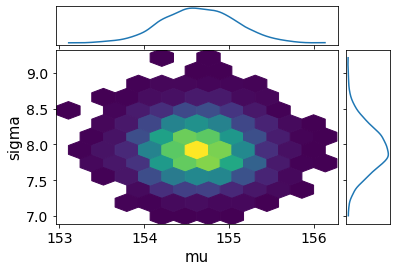

In [21]:
# 1.
az.plot_pair(fit, var_names=("mu", "sigma"), kind="hexbin", marginals=True)
plt.show()

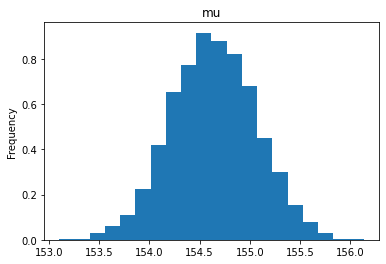

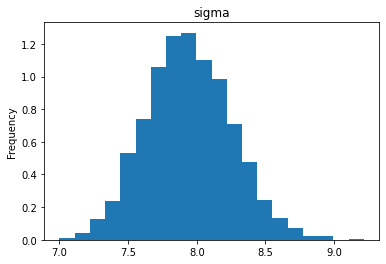

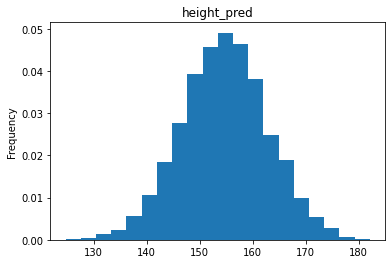

[]

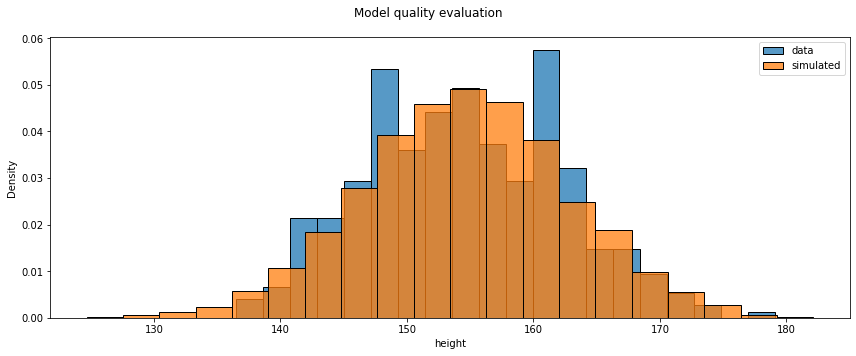

In [30]:
# 2.
for signal in ['mu', 'sigma', 'height_pred']:
    df_2[signal].plot.hist(bins=20, density=True)
    plt.title(signal)
    plt.show()


fig, ax = plt.subplots(figsize=(12,5))
fig.suptitle("Model quality evaluation")
sns.histplot(data=d, x="height", bins=20, stat="density", ax=ax, label='data')
sns.histplot(data=df_2, x="height_pred", bins=20, stat="density", ax=ax, label='simulated')
plt.legend()
plt.tight_layout()
plt.plot()

Simulation is OK.

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [31]:
c_weight = d.weight-d.weight.mean()
d['c_weight'] = c_weight
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}


## Task 4. Prior predictive checks
 

In [32]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /home/Lab_4/height_2a_ppc.stan to exe file /home/Lab_4/height_2a_ppc
INFO:cmdstanpy:compiled model executable: /home/Lab_4/height_2a_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

In [33]:
df_4 = sim.draws_pd()
df_4

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,191.665,0.777181,13.7277,182.599,162.280,185.239,198.822,213.971,...,217.062,227.453,223.245,206.186,184.146,196.238,200.401,215.128,209.066,214.492
1,0.0,0.0,160.409,-0.006780,14.9963,178.721,171.889,171.587,178.157,178.679,...,200.412,159.956,146.819,157.962,146.022,168.035,144.686,158.799,179.852,159.148
2,0.0,0.0,166.584,-1.138640,13.7781,201.950,179.098,178.741,188.546,184.894,...,176.857,133.758,172.130,155.169,176.776,149.190,162.021,153.756,146.279,149.028
3,0.0,0.0,162.143,-0.254452,14.4921,184.945,155.957,162.196,151.371,161.824,...,167.149,161.133,164.401,179.353,152.018,151.279,170.996,150.954,163.607,152.397
4,0.0,0.0,162.052,1.671020,14.2973,101.473,131.426,129.762,130.995,161.655,...,204.814,202.167,174.066,188.155,184.725,181.334,181.274,200.793,199.272,180.499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,163.501,1.261300,14.3942,160.144,123.793,149.038,148.851,152.509,...,187.398,144.736,192.999,176.683,220.439,179.108,183.454,215.341,179.310,171.692
996,0.0,0.0,177.345,1.223380,15.6785,170.826,170.885,155.366,165.607,142.222,...,184.830,201.786,201.974,167.755,209.471,189.494,164.920,218.821,193.424,196.394
997,0.0,0.0,167.917,-0.272051,12.2000,165.760,186.796,181.066,172.447,174.697,...,156.613,159.188,171.557,142.114,165.316,173.815,149.693,166.933,153.536,157.094
998,0.0,0.0,149.246,0.987160,13.7746,147.814,139.461,134.262,145.072,155.579,...,157.222,159.068,136.505,151.409,179.107,161.456,180.983,150.842,147.390,169.983


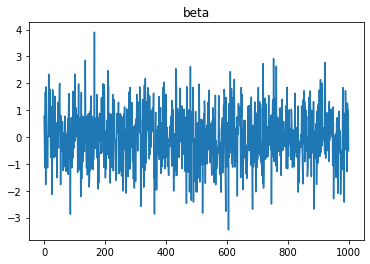

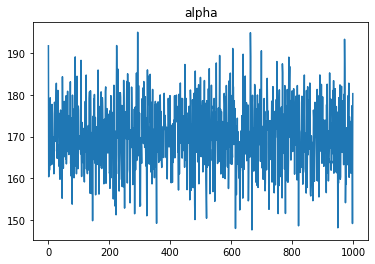

In [34]:
for signal in ['beta', 'alpha']:
    plt.plot(df_4[signal])
    plt.title(signal)
    plt.show()

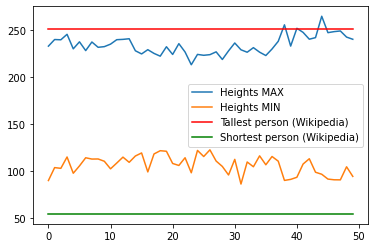

In [40]:
heights_max = []
heights_min = []
for i in range(1, 51):
    height_num = "height[" + str(i) + "]"
    heights_max.append(df_4[height_num].max())
    heights_min.append(df_4[height_num].min())

plt.plot(heights_max, label='Heights MAX')
plt.plot(heights_min, label='Heights MIN')
plt.plot([251] * len(heights_max), label='Tallest person (Wikipedia)', color='red')
plt.plot([54] * len(heights_max), label='Shortest person (Wikipedia)', color='green')
plt.legend()
plt.show()

Almost every predicted height is possible.

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [41]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:compiling stan file /home/Lab_4/height_2b_ppc.stan to exe file /home/Lab_4/height_2b_ppc
INFO:cmdstanpy:compiled model executable: /home/Lab_4/height_2b_ppc


In [42]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

In [43]:
df_5 = sim.draws_pd()
df_5

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,191.665,1.214450,12.45550,176.350,158.246,179.409,192.065,206.141,...,220.890,230.650,227.164,212.018,192.352,203.656,207.765,221.459,216.290,221.545
1,0.0,0.0,160.409,0.998307,14.99260,164.727,158.551,158.904,166.127,167.304,...,212.603,172.811,160.332,172.127,160.846,183.508,160.819,175.584,197.287,177.242
2,0.0,0.0,166.584,0.752270,12.55630,173.899,154.240,155.080,165.181,163.020,...,197.674,159.563,195.698,181.407,202.264,178.291,191.150,184.784,179.136,182.807
3,0.0,0.0,162.143,0.938368,13.98420,167.667,140.466,147.258,137.583,148.441,...,181.345,176.311,180.235,195.434,169.829,169.888,189.685,171.117,184.097,174.052
4,0.0,0.0,162.052,1.518550,13.59450,105.430,133.864,132.237,133.363,162.470,...,201.858,199.296,172.530,185.881,182.574,179.304,179.201,197.715,196.222,178.326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,163.501,1.370700,13.78850,158.024,123.308,147.597,147.523,151.133,...,188.365,147.604,193.942,178.418,220.439,180.953,185.222,215.873,181.464,174.272
996,0.0,0.0,177.345,1.357770,16.35690,169.410,169.525,153.388,164.124,139.780,...,186.143,203.885,204.135,168.488,212.062,191.274,165.689,221.976,195.533,198.685
997,0.0,0.0,167.917,0.934248,9.39993,150.333,167.286,163.616,157.721,160.200,...,173.092,175.822,186.097,164.157,182.779,190.073,172.232,186.260,176.683,180.170
998,0.0,0.0,149.246,1.279910,12.54910,142.644,135.282,130.794,140.889,150.710,...,161.132,163.062,142.754,156.580,182.062,166.229,184.267,157.055,154.158,174.989


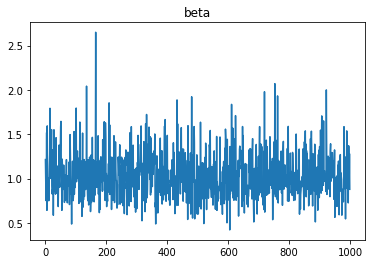

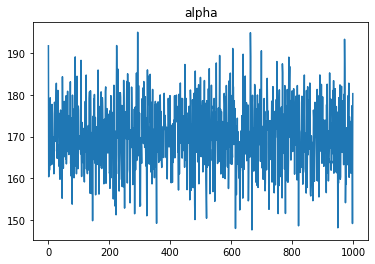

In [44]:
# 1.
for signal in ['beta', 'alpha']:
    plt.plot(df_5[signal])
    plt.title(signal)
    plt.show()

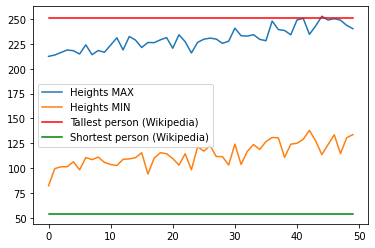

In [46]:
# 2.
heights_max = []
heights_min = []
for i in range(1, 51):
    height_num = "height[" + str(i) + "]"
    heights_max.append(df_5[height_num].max())
    heights_min.append(df_5[height_num].min())

plt.plot(heights_max, label='Heights MAX')
plt.plot(heights_min, label='Heights MIN')
plt.plot([251] * len(heights_max), label='Tallest person (Wikipedia)', color='red')
plt.plot([54] * len(heights_max), label='Shortest person (Wikipedia)', color='green')
plt.legend()
plt.show()

## Task 6. Fitting and evaluating model


In [48]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [49]:
N=50
data_fit = {'N':50, 'heights': d['height'].head(50), 'weight': d['weight'].head(50)}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


In [50]:
df_6 = fit.draws_pd()
df_6

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,height_pred[41],height_pred[42],height_pred[43],height_pred[44],height_pred[45],height_pred[46],height_pred[47],height_pred[48],height_pred[49],height_pred[50]
0,-149.473,0.997664,0.314947,3.0,7.0,0.0,149.872,138.429,13.1110,0.383509,...,151.458,173.163,173.051,149.155,166.740,160.350,166.516,156.028,168.597,150.121
1,-149.225,0.999471,0.314947,4.0,15.0,0.0,150.047,124.037,11.4782,0.659539,...,140.255,173.644,148.284,158.312,156.316,150.833,162.221,146.527,144.650,143.280
2,-148.912,0.993617,0.314947,3.0,15.0,0.0,151.348,130.053,13.5126,0.560340,...,147.649,165.952,173.778,166.557,168.919,159.330,152.468,148.594,149.909,141.549
3,-148.021,0.992753,0.314947,3.0,15.0,0.0,149.620,127.863,11.6265,0.594381,...,174.039,162.218,160.634,159.692,173.380,160.816,160.317,141.741,170.353,151.998
4,-148.218,0.841035,0.314947,3.0,15.0,0.0,149.811,132.994,12.4711,0.523764,...,145.147,166.233,135.674,153.769,171.615,168.415,171.024,177.213,194.805,161.762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-152.415,0.918259,0.337894,2.0,3.0,0.0,152.646,118.754,12.2205,0.748248,...,143.082,176.802,172.927,153.023,140.979,165.460,142.366,178.257,153.672,160.481
3996,-149.860,0.866920,0.337894,3.0,7.0,0.0,153.939,124.332,12.4878,0.618021,...,154.808,153.720,169.035,128.892,158.027,151.702,172.363,177.425,164.825,148.528
3997,-148.702,0.997645,0.337894,4.0,15.0,0.0,149.874,136.019,11.2503,0.447867,...,153.794,171.442,140.328,158.728,155.619,140.843,151.814,162.678,141.922,154.435
3998,-149.725,0.691555,0.337894,2.0,3.0,0.0,151.202,133.187,11.3322,0.410776,...,147.623,156.048,171.915,146.873,163.660,148.847,157.288,156.035,167.857,162.339


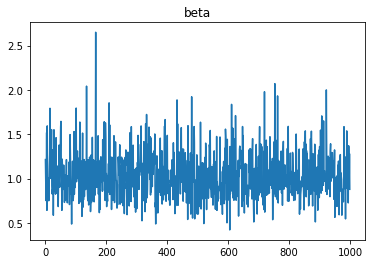

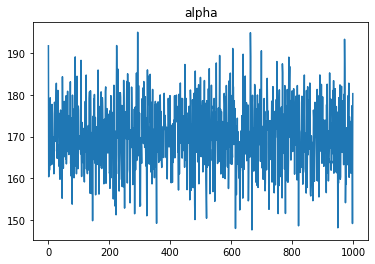

In [51]:
# 1.
for signal in ['beta', 'alpha']:
    plt.plot(df_5[signal])
    plt.title(signal)
    plt.show()

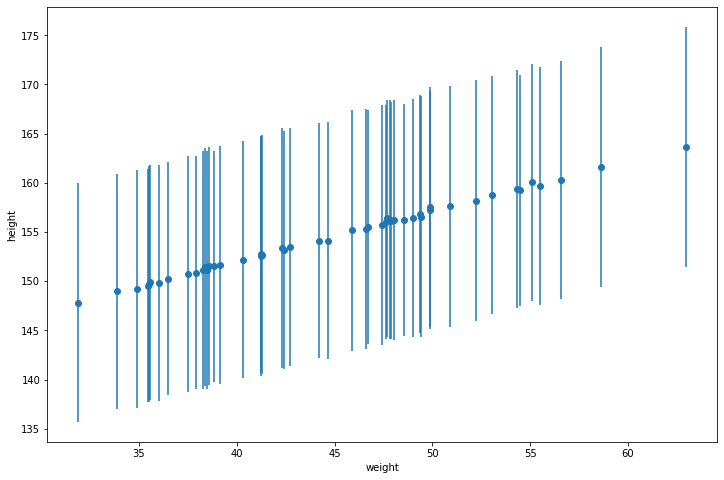

In [53]:
#2.
weights = d['weight'].head(50)
heights = df_6.iloc[:,60:110]
std = heights.std()[:50]
mean = heights.mean()[:50]

plt.figure(figsize=(12,8))
plt.errorbar(weights, mean, yerr=std, fmt='o', elinewidth = 1.5)
plt.xlabel('weight')
plt.ylabel('height')
plt.show()

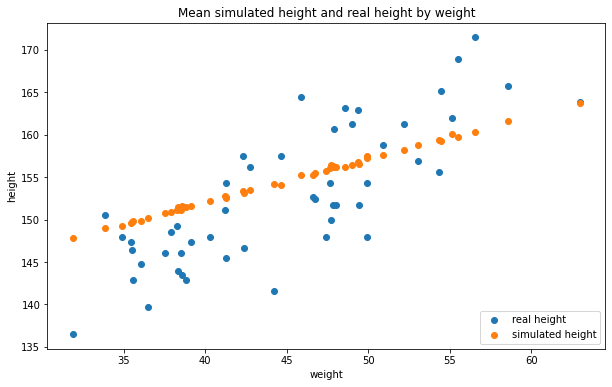

In [54]:
real_heights = d['height'].head(50)

plt.figure(figsize=(10,6))
plt.scatter(weights, real_heights)
plt.scatter(weights, mean)
plt.title("Mean simulated height and real height by weight")
plt.xlabel('weight')
plt.ylabel('height')
plt.legend(["real height", "simulated height"], loc='lower right')
plt.show()

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

In [55]:
data_fit7={'N':50, 'heights': d['height'].head(50), 'weight':d['c_weight'].head(50)}
fit=model_2_fit.sample(data=data_fit7,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [56]:
df_7 = fit.draws_pd()
df_7

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,height_pred[41],height_pred[42],height_pred[43],height_pred[44],height_pred[45],height_pred[46],height_pred[47],height_pred[48],height_pred[49],height_pred[50]
0,-134.333,0.962576,0.777072,3.0,7.0,0.0,135.279,154.064,11.5889,0.702025,...,144.283,172.315,154.418,157.237,174.801,166.062,170.641,136.889,157.836,165.890
1,-133.514,0.997371,0.777072,3.0,7.0,0.0,134.746,153.085,10.8085,0.919494,...,146.337,183.619,136.827,152.716,145.959,175.383,163.927,169.069,142.217,177.978
2,-135.621,0.809256,0.777072,3.0,7.0,0.0,136.653,152.140,13.5648,1.033990,...,158.117,175.466,134.892,152.233,141.014,163.226,160.837,149.946,160.776,171.130
3,-134.630,1.000000,0.777072,2.0,3.0,0.0,135.581,151.983,12.7357,1.040630,...,131.292,178.733,129.170,165.255,148.212,185.405,172.831,155.456,163.505,137.856
4,-134.093,1.000000,0.777072,2.0,3.0,0.0,134.891,153.259,12.5120,1.069140,...,157.115,148.353,164.409,150.154,157.618,164.676,184.849,158.944,170.148,157.578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-134.262,0.753939,0.827173,2.0,7.0,0.0,137.701,152.266,12.0405,1.092100,...,170.795,169.752,137.346,150.194,173.759,171.660,152.388,169.958,158.717,141.794
3996,-133.591,0.980164,0.827173,2.0,7.0,0.0,134.641,152.356,11.4726,0.953501,...,169.243,179.802,161.237,152.503,155.809,154.718,161.395,163.382,157.350,174.606
3997,-134.352,0.852889,0.827173,2.0,3.0,0.0,135.073,155.943,12.1262,0.911222,...,164.846,184.895,143.172,154.113,166.180,162.801,135.729,153.924,171.484,155.919
3998,-136.539,0.834350,0.827173,2.0,3.0,0.0,137.144,151.732,10.8613,1.275190,...,141.825,160.624,139.892,149.560,175.844,157.569,164.257,165.014,166.936,152.120


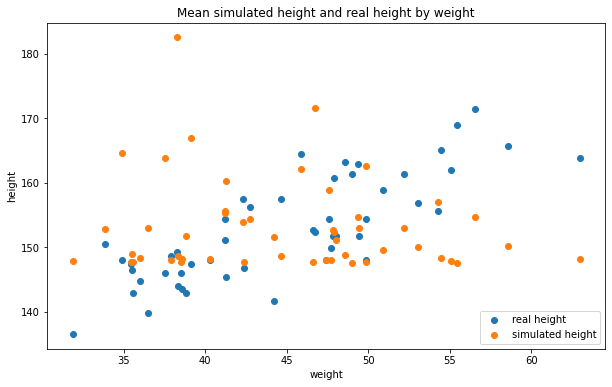

In [61]:
real_heights = d['height'].head(50)
heights = df_7.iloc[:,60:110]
mean = heights.mean()[:50]
plt.figure(figsize=(10,6))
plt.scatter(weights, real_heights)
plt.scatter(weights, mean)
plt.title("Mean simulated height and real height by weight")
plt.xlabel('weight')
plt.ylabel('height')
plt.legend(["real height", "simulated height"], loc='lower right')
plt.show()